In [3]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import scipy.io.wavfile as wav
from typing import List
import sys
sys.path.append('/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/midi')#TODO change helper.py file so inharmoniicity is from . and also change midi file so sharedtypes is in lib rather than midi folder
from midi import process_midi_to_note_info, notes_to_chords, dict_to_frequency_list, plot_piece

sys.path.append('/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/GP_models')
import helper


In [4]:
# Return hidden score states 
from librosa import hz_to_note
note_info = process_midi_to_note_info('/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/midi_files/hymn.midi')
dic = notes_to_chords(note_info, sustain=False)
score, time_to_next, cumulative= dict_to_frequency_list(dic)

    

In [5]:
# Create cov_dict

cov_dict = {}
sample_length = 700
sample_rate = 44100
M=9
transition=0.465
v=2.37
sigma_f=1/500000
sigma_n=5
time_samples = np.linspace(0, sample_length/sample_rate, sample_length)
max_d = 50

for state in score[:1000]:
    if str(state) not in cov_dict:
        cov_dict[str(state)] = helper.SM_kernel(
            time_samples, time_samples, M=M,  f=state, sigma_f=sigma_f, T=transition, v=v) + sigma_n**2 * np.eye(sample_length)

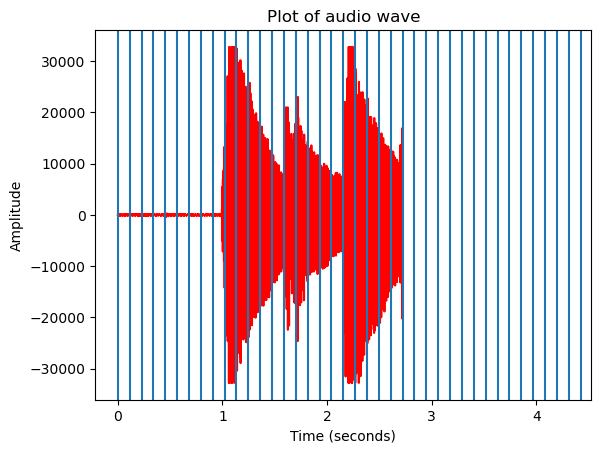

In [6]:
# Return observed state elements as a list of np.arrays called audio_data

# Define arguments
hop_length = 5000

show = 120000

performance_path = '/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/wav_files/hymn6.wav'
sample_rate, data = wav.read(performance_path)

performance_duration = len(data)/sample_rate

time_samples = np.linspace(0, performance_duration, len(data))
sample_indices = np.arange(0, len(data), hop_length) 
audio_data = [data[index:index+sample_length] for index in sample_indices]

# Plot data to help visualise it
helper.plot_audio(time_samples[:show], data[:show])
for i in sample_indices[:40]:
    plt.axvline(i/sample_rate)


In [7]:
def viterbi(y: List[np.ndarray], states: List[list], sample_rate: int = 44100, cov_dict: dict = cov_dict):
    """
    Return the optimal state path of the Hidden Markov Model

    Parameters
    y: Observed state sequence
    T: State transition matrix (K, K) of K states
    E: Emission matrix?
    """

    sample_length = len(y[0]) # Assuming all samples are the same length
    K = len(states) # Number of states
    n = len(y) # Number of audio samples
    gamma = np.full((K, n), -np.inf, 'd') # Matrix to hold probabilities
    delta = np.zeros((K, n), 'B') # Back pointers 
    time_samples = np.linspace(0, sample_length/sample_rate, sample_length)
    max_s = 0
    path = []
    w = 6
    chunk = 0
    step = w //3
    counter = []
    conversion_rate = None
    d = 1 # d tracks the duration number (ie this incremements each time we perform a self transition)
    scale_factor = 0.05
    threshold: float = 80000000
    state_duration = False
    j = 1
  
    # Initialise prior state (we will assume we start at the first state)
    # TODO think about the inital state and decide what to do about the silence at first
    lml = -helper.stable_nlml(time_samples, y[0], M=9, normalised=False, f=states[0], T=0.465, v=2.37, cov_dict=cov_dict)
    lml_scaled = np.sign(lml) * np.abs(lml)**scale_factor
    gamma[0, 0] = lml_scaled
    path.append(0)

    advance_transition = np.log(0.5)
    self_transition = np.log(0.5)

    # Iterate through observations
    for i in range(1, n):
        sum = np.sum(np.array(y[i], dtype=np.int64)**2)
        print(sum)
        if sum <= threshold:
            print(f"Amplitude too small, moving onto next audio frame")
            path.append(0)
            d += 1
        else:

            print("Gamma column j : ",j, "audio frame i:", i)            

            if state_duration:
                # Calculate transition probabilities TODO this is way too small relatively
                expected = conversion_rate * time_to_next[max_s]/1000
                p = 1 / expected # probability 
                q = 1 - p
                advance_transition = np.sum([q**z * p for z in range(d)])
                self_transition = np.log(1 - advance_transition)
                # advance_transition = np.log(advance_transition)

            k0_index = chunk * step
            for k in range(k0_index, k0_index + w):

                lml = -helper.stable_nlml(time_samples, y[i], M=9, normalised=False, f=states[k], T=0.465, v=2.37, cov_dict=cov_dict)  
                lml_scaled = np.sign(lml) * np.abs(lml)**scale_factor
                # print("state ", k, "lml ", lml_scaled, "probability of staying the same: ", gamma[k,j-1], "probability of having been the previous: ", gamma[k-1,j-1])
                print("k is ", k, "lml scaled is", lml_scaled)
                same_state = lml_scaled + gamma[k,j-1] + self_transition
                advance_state = lml_scaled + gamma[k-1, j-1] +  advance_transition
                print("k is ", k, "same ", same_state, "(checking...)",  gamma[k,j-1])
                print("k is ", k, "advance ", advance_state)

                if same_state >= advance_state:
                    gamma[k, j] = same_state
                    delta[k, j] = k
                else:
                    gamma[k, j] = advance_state
                    delta[k, j] = k - 1
            
            
            print(gamma[0:k0_index+w, j])
            new_s = np.argmax(gamma[:,j])

            if new_s == max_s:
                d += 1 # increment count 
            else:
                counter.append(d)
                conversion_rates = 1000 * np.array(counter)/ np.array(time_to_next[:len(counter)]) # Multiply by 1000 to make seconds
                conversion_rate =  np.mean(conversion_rates) # Conversion is how many durations counts d per second. We take the running mean average
                d = 1

            max_s = new_s
            print('appending: ', max_s)
            path.append(max_s)

            if max_s >= k0_index + w - step:
                chunk += 1

            j += 1
        
        # Build the optimal path, for comparison to live output
        optimal_path = np.zeros(n, 'B')
        optimal_path[-1] = np.argmax(gamma[:, n-1])

        for i in reversed(range(1, n)):
            optimal_path[i-1] = delta[optimal_path[i], i]

    return path, optimal_path,counter, gamma


path, optimal, counter , gamma= viterbi(audio_data[:90],  score[:90], cov_dict=cov_dict )
print(path, optimal)

    

3801029
Amplitude too small, moving onto next audio frame
9354381
Amplitude too small, moving onto next audio frame
2562158
Amplitude too small, moving onto next audio frame
29095266
Amplitude too small, moving onto next audio frame
3828113
Amplitude too small, moving onto next audio frame
3789996
Amplitude too small, moving onto next audio frame
3987624
Amplitude too small, moving onto next audio frame
2744275
Amplitude too small, moving onto next audio frame
46364574449
Gamma column j :  1 audio frame i: 9
k is  0 lml scaled is -2.6399925833722806
k is  0 same  -5.109678108418314 (checking...) -1.776538344486088
k is  0 advance  -inf
k is  1 lml scaled is -2.7930017980992075
k is  1 same  -inf (checking...) -inf
k is  1 advance  -5.262687323145241
k is  2 lml scaled is -2.6613821960904667
k is  2 same  -inf (checking...) -inf
k is  2 advance  -inf
k is  3 lml scaled is -2.7395581975680567
k is  3 same  -inf (checking...) -inf
k is  3 advance  -inf
k is  4 lml scaled is -2.71609420195

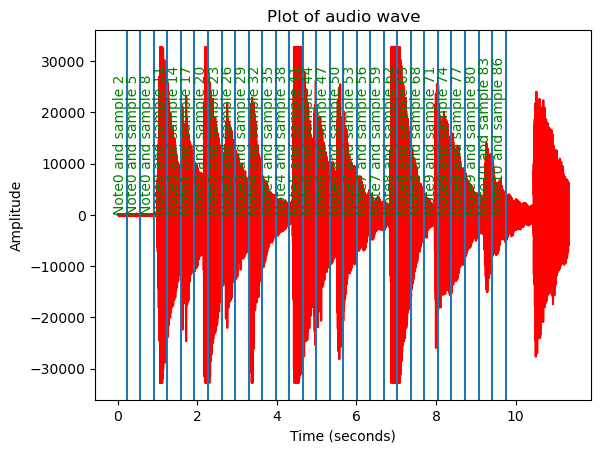

In [8]:
time_samples = np.linspace(0, performance_duration, len(data))
show = 500000
# Plot data to help visualise it
helper.plot_audio(time_samples[:show], data[:show])
for _, i in enumerate(sample_indices[:89]):
    if (_+1) %3 == 0:
        plt.axvline(i/sample_rate)
        plt.text(sample_indices[_]/sample_rate, 0.3, f'Note{path[_]} and sample {_}', color='green', ha='right', va='bottom', rotation=90, fontsize=10)
    

In [88]:
print(score[27])
print(score[28])
print(score[29])
# print(score[5])
print(len(audio_data[0]))

[330]
[440, 349, 262, 175]
[349, 392, 294, 117]
700


/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/GP_models/least_squares.py:17: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, data = wav.read(wav_file)


28238427521
-2041.325634977713
-2023.6196537352735
-1702.183849745525


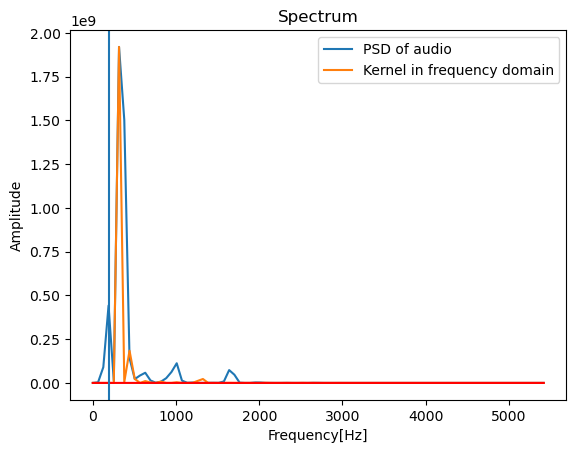

In [108]:
import least_squares
time_samples = np.linspace(0, len(audio_data[0])/sample_rate, 700)
a = abs(least_squares.opt_amplitude(audio_data[210], show=True, T=2,v=5,  f=[329, 415, 493, 659,831])[0])
sum =  np.sum(np.array(audio_data[210], dtype=np.int64)**2)
print(sum)
helper.plot_fft(audio_data[210])
plt.axvline(196)
# plt.axvline(262)
# plt.axvline(170)
# plt.axvline(233) # not real
j=210

print(-helper.stable_nlml(time_samples, audio_data[j], M=9, normalised=False, f=[330, 196], T=0.465, v=2.37, sigma_n =0.00020,sigma_f =1/500000,cov_dict=None )**0.2)
lml = -helper.stable_nlml(time_samples, audio_data[j], M=9, normalised=False, f=score[28], T=0.465, v=2.37, sigma_n =0.00020,sigma_f =1/500000,cov_dict=None)
lml_scaled = np.sign(lml) * np.abs(lml)**0.2
print(lml_scaled)
print(-helper.stable_nlml(time_samples, audio_data[j], M=9, normalised=False, f=score[29], T=0.465, v=2.37, sigma_n =0.00020,sigma_f =1/500000,cov_dict=None)**0.2)
# print(-helper.stable_nlml(time_samples, audio_data[j], M=9, normalised=False, f=score[8], T=0.465, v=2.37, sigma_n =1,sigma_f =1/500000,cov_dict=None)**0.2)


In [11]:
print(gamma[0:10,15:20])

[[-52.1064572  -55.51993193 -58.91134779 -62.20377208 -65.41032136]
 [-51.60572102 -55.12964932 -58.57914663 -61.9352184  -65.22992361]
 [-51.17018284 -54.60490575 -58.00484031 -61.29299181 -64.49198709]
 [-51.33823101 -54.60982572 -57.90742924 -61.11212868 -64.24653158]
 [-51.50928943 -54.88409796 -58.04658354 -61.20576399 -64.33368321]
 [-51.56761622 -54.90751347 -58.21849355 -61.29667759 -64.41193164]
 [        -inf         -inf         -inf         -inf         -inf]
 [        -inf         -inf         -inf         -inf         -inf]
 [        -inf         -inf         -inf         -inf         -inf]
 [        -inf         -inf         -inf         -inf         -inf]]


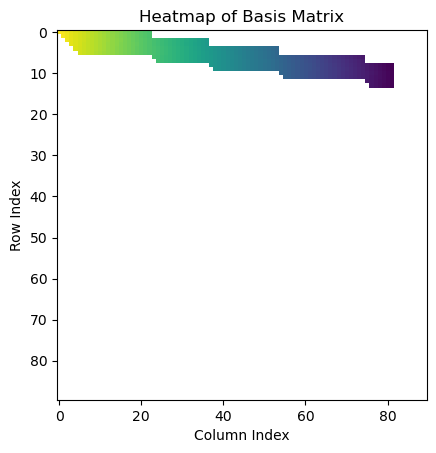

In [12]:
# Use imshow to plot the matrix as a heatmap
plt.imshow(gamma, cmap='viridis', interpolation='nearest')

# Set axis labels and title
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.title('Heatmap of Basis Matrix')

# Show the plot
plt.show()

In [13]:
print(score[:8])
score[3] = [262, 330, 392, 523]

[[440, 349, 294, 294], [262], [349, 587, 294, 233], [392, 330], [523, 440, 349, 220], [294, 466, 392, 196], [330], [440, 349, 262, 175]]


In [14]:
# Create cov_dict

cov_dict = {}
sample_length = 1000
sample_rate = 44100
M=9
transition=0.465
v=2.37
sigma_f=1/500000
sigma_n=100
time_samples = np.linspace(0, sample_length/sample_rate, sample_length)
max_d = 50

for state in score[:10]:
    if str(state) not in cov_dict:
        cov_dict[str(state)] = helper.SM_kernel(
            time_samples, time_samples, M=M,  f=state, sigma_f=sigma_f, T=transition, v=v) + sigma_n**2 * np.eye(sample_length)

In [15]:
lml.append(-helper.stable_nlml(time_samples, audio_data[20], M=9, normalised=False, f=score[5], T=0.465, v=2.37, cov_dict=cov_dict, amplitude=[])  )

NameError: name 'lml' is not defined

[[440, 349, 294, 294], [262], [349, 587, 294, 233], [392, 330], [523, 440, 349, 220], [294, 466, 392, 196], [330], [440, 349, 262, 175], [349, 392, 294, 117], [330, 262, 131], [440, 349, 262, 175], [659, 440, 330, 139], [698, 440, 147, 330], [165], [698, 440, 175, 294], [196], [659, 440, 294, 220], [587], [440, 659, 277, 110], [392], [587, 349, 220, 147], [440, 349, 294, 294], [262], [349, 587, 294, 233], [392, 330], [523, 440, 349, 220], [294, 466, 392, 196], [330], [440, 349, 262, 175], [349, 392, 294, 117], [330, 262, 131], [440, 349, 262, 175], [659, 440, 330, 139], [698, 440, 147, 330], [165], [698, 440, 175, 294], [196], [659, 440, 294, 220], [587], [440, 659, 277, 110], [392], [587, 349, 220, 147], [698, 440, 294, 147], [262], [659, 392, 233, 196], [587], [392, 523, 262, 220], [349], [587, 349, 233, 262], [220], [659, 466, 233, 196], [262], [466, 698, 294, 175], [440, 262], [392, 233], [698, 440, 262, 175], [523, 440, 349, 175], [311], [440, 587, 294, 233], [392], [523, 440, 294

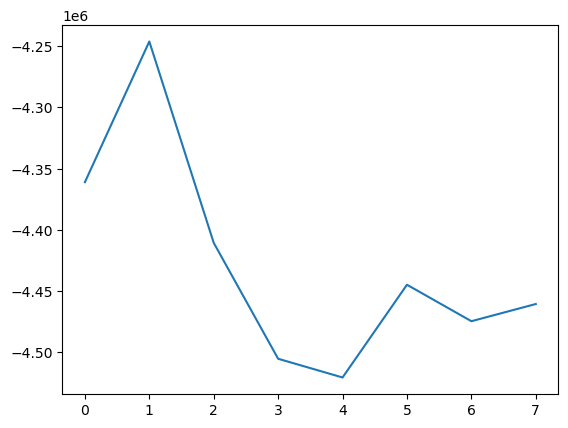

In [ ]:
# # helper.plot_fft(audio_data[7])

# print(score[2])
# plt.axvline(349)
# plt.axvline(587)
# plt.axvline(294)
# plt.axvline(233)
print(score)
lml = []
for i in range(8):
    lml.append(-helper.stable_nlml(time_samples, audio_data[9], M=9, normalised=False, f=score[i], T=0.465, v=2.37, cov_dict=cov_dict)  )
plt.plot(lml)

In [ ]:
print(-helper.stable_nlml(time_samples, audio_data[3], M=8, normalised=False, f=[262], T=0.465, v=2.37, cov_dict=cov_dict) )
print(-helper.stable_nlml(time_samples, audio_data[3], M=8, normalised=False, f=[440, 349, 294, 294], T=0.465, v=2.37, cov_dict=cov_dict) )

-2920551.7250153376
-2884226.928814967


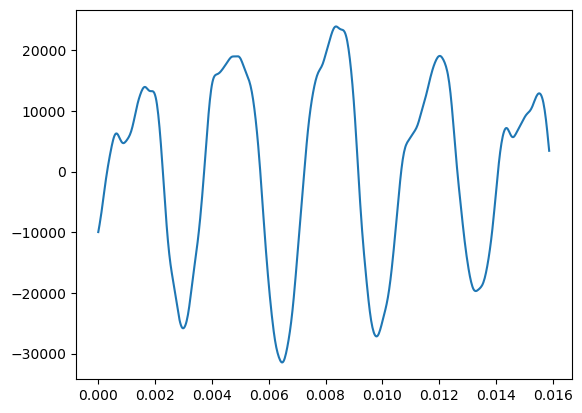

In [ ]:
time_samples = np.linspace(0, len(audio_data[0])/sample_rate, sample_length)
plt.plot(time_samples,audio_data[7])


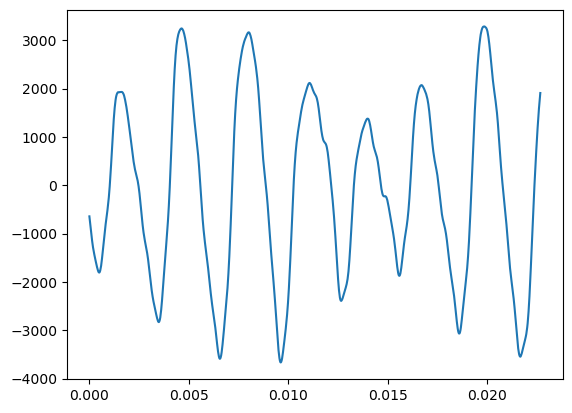

In [ ]:
plt.plot(time_samples,audio_data[5])